In [1]:
# Analyze barcoder

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from Bio import SeqIO
import gzip
import os
import time
import glob
from concurrent.futures import ProcessPoolExecutor
import pickle
import sys
sys.path.append('/home/emre/github_repo/MinION')
from minION.util import IO_processor
from minION.util.globals import DEFAULT_TARGETS
from pathlib import Path
import concurrent.futures

import importlib as imp 
imp.reload(IO_processor)


<module 'minION.util.IO_processor' from '/home/emre/github_repo/MinION/minION/util/IO_processor.py'>

In [2]:
result_folder = "/home/emre/minION_results/MinION_RBC_0902723_sup"

experiment_folder = IO_processor.find_experiment_folder("Masked_3RBC-Minion")

file_path = IO_processor.find_experiment_files(experiment_folder, ["fastq_pass"])

files = IO_processor.extract_files_from_folder(Path(file_path))

In [14]:
# for i,file in enumerate(files):
#     IO_processor.filter_fastq_by_length(result_folder, input_fastq=file, min_length=850, max_length=950, ind=i)

# Make it parallel with ThreadPoolExecutor

# with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
#     executor.map(IO_processor.filter_fastq_by_length, [result_folder]*len(files), files, [850]*len(files), [950]*len(files), range(len(files)))

In [25]:
# for key, value in DEFAULT_TARGETS.items():
#     file_path = IO_processor.find_experiment_files(experiment_folder, value)


None
/var/lib/minknow/data/Masked_3RBC-Minion/1/20230926_1648_MN41105_FAX47927_8a712363/fastq_pass


In [2]:
def process_gzip_files(filename):
    
    # Open the gzip-compressed FASTQ file for reading
    with gzip.open(filename, 'rt') as handle:
        for record in SeqIO.parse(handle, "fastq"):
            # Access various attributes of the FASTQ record
            print("ID:", record.id)
            print("Sequence:", record.seq)
            print("Quality Scores:", record.letter_annotations["phred_quality"])
            print("\n-----\n")


def filter_single_chunk(records, min_length, max_length):
    """Filter a chunk of FASTQ records based on length."""
    return [record for record in records if min_length <= len(record.seq) <= max_length]

def filter_sequences(filename, min_length=650, max_length=1000, output_file="filtered_sequences.fastq.gz", n_workers=4):
    """Filter basecalled sequences based on length in parallel.
    
    Args:
        filename (str): .fastq.gz file name
        min_length (int): minimum length of sequence
        max_length (int): maximum length of sequence
        output_file (str): output file name for filtered sequences
        n_workers (int): number of processes for parallel processing

    Returns:
        str: Fastq file name with filtered sequences
    """
    
    # Break records into chunks for parallel processing
    chunk_size = 1000  # You can adjust this value based on your requirements
    all_records = []
    with gzip.open(filename, 'rt') as handle:
        all_records = list(SeqIO.parse(handle, "fastq"))
    chunks = [all_records[i:i + chunk_size] for i in range(0, len(all_records), chunk_size)]
    
    filtered_records = []
    
    # Parallel processing of chunks
    with ProcessPoolExecutor(max_workers=n_workers) as executor:
        futures = [executor.submit(filter_single_chunk, chunk, min_length, max_length) for chunk in chunks]
        for future in futures:
            filtered_records.extend(future.result())

    # Write filtered sequences to the output file
    with open(output_file, 'wt') as output_handle:
        SeqIO.write(filtered_records, output_handle, "fastq")

    return output_file

def get_seq_dist(filename):
    """
    Get Sequence distribution of .fastq files of the experiment

    Args:
        filename (str): .fastq file name
    
    Returns:
        seq_dist (list): list of length of each sequence
    """
    
    seq_dist = []
    with gzip.open(filename, 'rt') as handle:
        for record in SeqIO.parse(handle, "fastq"):
            seq_dist.append(len(record.seq))
    return seq_dist


In [4]:
files[0]

PosixPath('/var/lib/minknow/data/Masked_3RBC-Minion/1/20230926_1648_MN41105_FAX47927_8a712363/fastq_pass/FAX47927_pass_8a712363_32e989f2_954.fastq.gz')

In [4]:
result_folder = "/home/emre/minION_results"
experiment_folder = "MinION_RBC_0902723_sup"

In [5]:
# Filter sequences based on length
filename = os.path.join(result_folder, experiment_folder, "basecalled.fastq.gz")
output_file = os.path.join(result_folder, experiment_folder, "basecalled.fastq")

filtered_sequences = filter_sequences(filename=filename, min_length=650, max_length=1000, output_file=output_file, n_workers=8)

KeyboardInterrupt: 

In [16]:
path = "/var/lib/minknow/data/Masked_3RBC-Minion/1/20230926_1648_MN41105_FAX47927_8a712363/fastq_pass/"

files = glob.glob(path + '*.fastq.gz')

# filename = os.path.join(path, 'FAX47927_pass_8a712363_32e989f2_1347.fastq.gz')

In [1]:
print("\"Barcode\"")

"Barcode"


In [6]:
# Open fastq
with open("/home/emre/minION_results/MinION_RBC_0902723_sup/basecalled/basecalled.fastq") as fastq_file:
    fastq = SeqIO.parse(fastq_file, "fastq")
    fastq_list = list(fastq)

# with open("/home/emre/minION_results/20230905_errorprone-3_test_sup/basecalled/basecalled.fastq") as fastq_file:
#     fastq = SeqIO.parse(fastq_file, "fastq")
#     fastq_list2 = list(fastq)

In [28]:
# Get Sequence length of each read
seq_len = []
for i in range(len(fastq_list)):
    seq_len.append(len(fastq_list[i].seq))

# seq_len2 = []
# for i in range(len(fastq_list2)):
#     seq_len2.append(len(fastq_list2[i].seq))



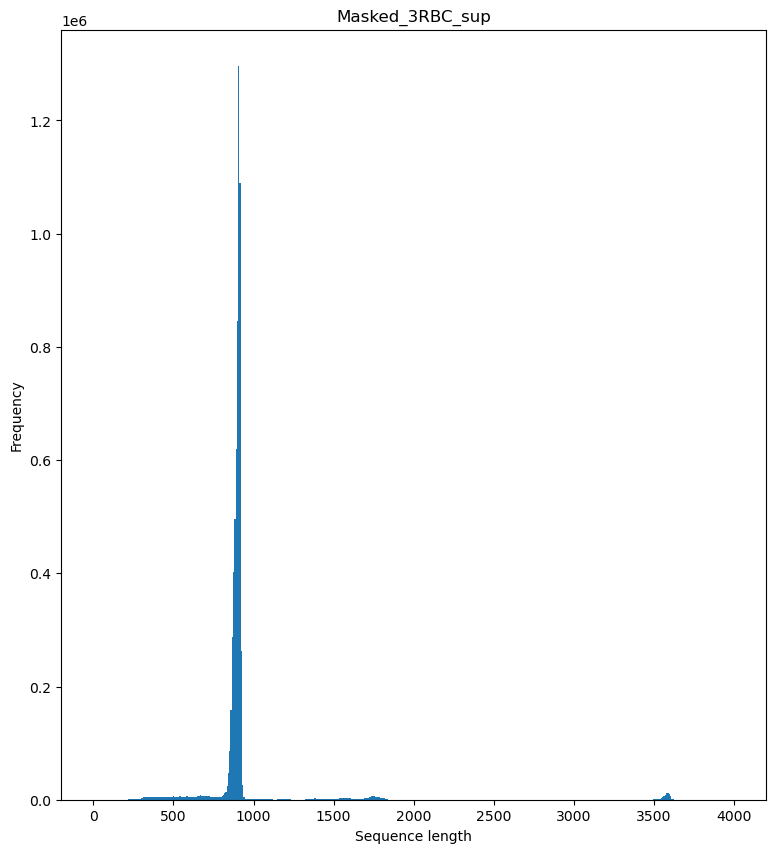

In [24]:
# Plot histogram of sequence length side by side

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)

plt.hist(seq_length, bins=500, range=(0,4000))
plt.title("Masked_3RBC_sup")
plt.xlabel("Sequence length")
plt.ylabel("Frequency")


# plt.subplot(1,2,2)
# plt.hist(seq_len2, bins=100, range=(0,1000))
# plt.title("20230905_errorprone-3_test_sup")
# plt.xlabel("Sequence length")
# plt.ylabel("Frequency")

plt.show()





In [21]:
fastq_list[0]

SeqRecord(seq=Seq('ACTGTTATAGTCTTCCTCGACGTTACGTATTGCTGGACCTCTTTCTCAGGGATA...TTG'), id='9c9f4dd1-0966-4dff-a094-c0efe5be3091', name='9c9f4dd1-0966-4dff-a094-c0efe5be3091', description='9c9f4dd1-0966-4dff-a094-c0efe5be3091', dbxrefs=[])

In [31]:
def filter_fastq_by_length(input_fastq : Path, output_fastq : Path, min_length : int , max_length : int):
    """
    Filter a FASTQ file based on read length and write to a new FASTQ file.

    Args:
        - input_fastq: Path to the input FASTQ file.
        - output_fastq: Path to the output FASTQ file.
        - min_length: Minimum length of reads to retain.
        - max_length: Maximum length of reads to retain.
    Returns:
        - Fastq file with reads between min_length and max_length.
        - N_reads
    """
    with open(input_fastq, 'r') as infile, open(output_fastq, 'w') as outfile:
        while True:
            

            header = infile.readline().strip()
            sequence = infile.readline().strip()
            plus_sign = infile.readline().strip()
            quality_scores = infile.readline().strip()

            if not header:
                break
            N_reads = 0
            if min_length <= len(sequence) <= max_length:
                outfile.write(f"{header}\n")
                outfile.write(f"{sequence}\n")
                outfile.write(f"{plus_sign}\n")
                outfile.write(f"{quality_scores}\n")
                N_reads += 1
    
    return N_reads

In [36]:
filter_fastq_by_length("/home/emre/minION_results/Masked_3RBC_sup/basecalled/basecalled.fastq", "/home/emre/minION_results/Masked_3RBC_sup/basecalled/basecalled_filtered.fastq", 680, 1100)

In [37]:
with open("/home/emre/minION_results/Masked_3RBC_sup/basecalled/basecalled_filtered.fastq") as file:
    file = SeqIO.parse(file, "fastq")
    file_list = list(file)

Text(0, 0.5, 'Frequency')

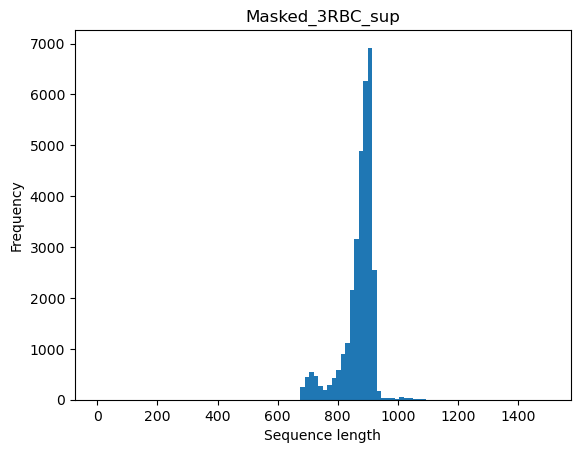

In [38]:
# Get Sequence length of each read
seq_len = []
for i in range(len(file_list)):
    seq_len.append(len(file_list[i].seq))

plt.hist(seq_len, bins=100, range=(0,1500))
plt.title("Masked_3RBC_sup")
plt.xlabel("Sequence length")
plt.ylabel("Frequency")

In [12]:
def find_anchors_with_mismatches(read, front_anchor, back_anchor, max_mismatches=1):
    read_len = len(read)
    front_len = len(front_anchor)
    back_len = len(back_anchor)
    
    potential_matches = []

    # Sliding window for front anchor
    for i in range(read_len - front_len + 1):
        window = read[i:i+front_len]
        if hamming_distance(window, front_anchor) <= max_mismatches:
            
            # Check for the back anchor, considering the barcode length and back anchor length
            for j in range(i + front_len + 24, read_len - back_len + 1):
                window_back = read[j:j+back_len]
                if hamming_distance(window_back, back_anchor) <= max_mismatches:
                    potential_matches.append((i, j))

    return potential_matches

def hamming_distance(str1, str2):
    """Compute the Hamming distance between two strings"""
    if len(str1) != len(str2):
        raise ValueError("Strings must be of the same length")
    return sum(c1 != c2 for c1, c2 in zip(str1, str2))

# Test
read = "GCTTAGGHYHZTAAACGTAGCTAGNNNNNNNNNNNNNNNNNNNNNNNNNNGTAGCATGCGTACGT"
front_anchor = "ATTGCTAAGGTT"
back_anchor = "CAGCACC"
matches = find_anchors_with_mismatches(read, front_anchor, back_anchor, max_mismatches=2)
print(matches)

[]


In [2]:
with open("/home/emre/minION_results/MinION_RBC_0902723_sup/qc/quality_summary.pkl", "rb") as file:
    quality_dist = pickle.load(file)

In [6]:
os.path.basename("/home/emre/minION_results/MinION_RBC_0902723_sup/basecalled_filtered/basecalled_filtered.fastq.gz")

'basecalled_filtered.fastq.gz'

In [10]:
from pathlib import Path

Path(Path("/home/emre/minION_results/MinION_RBC_0902723_sup/basecalled_filtered/basecalled_filtered.fastq.gz").stem).stem

'basecalled_filtered'

In [3]:
seq = "ATGTGCCTGTACTTCGTTCAGTTACGTATTGCTGGACGAAGAACTCAAGTCAAAGGCATCTCGATCCCGCGAAATTAATACGACTCACTATAGGGGAATTGTAAGCGGTTAACAATTCCCCCTCTAGAAATAATTTTGTTTAACTTTAGAGGAGATATACATATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGAAGTCACCCATCACGGACCTTGAGTTTGACCTTCTGAAGAAGACTGTCATGTTAGGTGAAAAGGACGTAATGTACTTGAAAAAGGCGCGTGACGTTCTGAAAGATCAAGTTGATGAGATCCTTGACTTGTGGGATGGTTGGGCGGCATCAAATGAGCATTTGATTTATTACTTCTCCAATCCGGATACAGGAGAGCCTATTAAGGAATACCTGGAACGTGTACGCGCTCGCTTTGAAGCCTGGATTCTGGACACTACCTGGCGCGACTATAACCGTGAATGGTTAGACTACCAGTACGAAGTTGGGCTTCGTCATCACCGTTCAAAGAAAGGGGTCACAGACGGAGTACGCACCGTGCCCCATATCCCACTTCGTTATCTTATCGCAAATATCTATCCTATCACCGCCACTATCAAGCCATTTTTGGCTAAGAAAGGTGGCTCTCCGGAAGACATCGAAGGGATGTACAACGCTTGGTTCAAGTCTGTAGTTTTACAAGTTGCCATCTGGTCACACCCTTATACTAAGGGGAATGACTGGCTCGAGCACCACCACCACCACCACTGAGATCCGGCTGCTAACAAAGCCCGAAAGGAAGCTGAGTTGGCTGCTGCCACCGCTGAGCAATAACTAGCATAACCCCTTGGGGCGGTGCTGCCTGGTAACTGGGACACAAGACTCTTAACCTTAGCAATAGCAATACGTGG"
seq2 = "ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGAAGTCACCCATCACGGACCTTGAGTTTGACCTTCTGAAGAAGACTGTCATGTTAGGTGAAAAGGACGTAATGTACTTGAAAAAGGCGCGTGACGTTCTGAAAGATCAAGTTGATGAGATCCTTGACTTGTGGGATGGTTGGGCGGCATCAAATGAGCATTTGATTTATTACTTCTCCAATCCGGATACAGGAGAGCCTATTAAGGAATACCTGGAACGTGTACGCGCTCGCTTTGGAGCCTGGATTCTGGACACTACCTGGCGCGACTATAACCGTGAATGGTTAGACTACCAGTACGAAGTTGGGCTTCGTCATCACCGTTCAAAGAAAGGGGTCACAGACGGAGTACGCACCGTGCCCCATATCCCACTTCGTTATCTTATCGCAAATATCTATCCTATCACCGCCACTATCAAGCCATTTTTGGCTAAGAAAGGTGGCTCTCCGGAAGACATCGAAGGGATGTACAACGCTTGGTTCAAGTCTGTAGTTTTACAAGTTGCCATCTGGTCACACCCTTATACTAAGGAGAATGACTGGCTCGAGCACCACCACCACCACCACTGA"

In [4]:
print(len(seq), len(seq2))

914 612
